## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    print('Running locally.')
    sys.path.append('./mae')
    sys.path.append('..')
    print(sys.path)
    !pip3 install timm==0.4.5
import models_mae

Running locally.
['/Users/atticusw/miniconda3/lib/python312.zip', '/Users/atticusw/miniconda3/lib/python3.12', '/Users/atticusw/miniconda3/lib/python3.12/lib-dynload', '', '/Users/atticusw/miniconda3/lib/python3.12/site-packages', './mae', '..', './mae', '..']


### Define utils

In [3]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, mask_ratio=0.75):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

In [4]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Base, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth

chkpt_dir = 'mae_visualize_vit_base.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')


File 'mae_visualize_vit_base.pth' already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


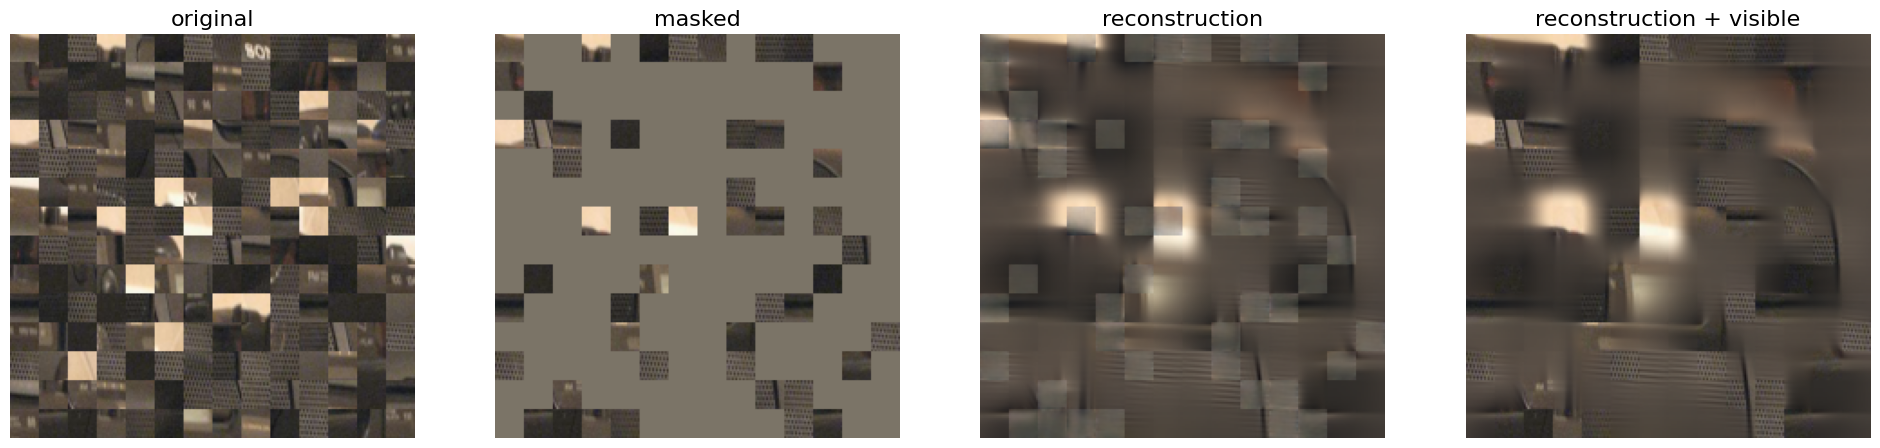

In [43]:
# make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

In [5]:
from datasets import load_dataset

ds = load_dataset("frgfm/imagenette", "320px")

Using the latest cached version of the dataset since frgfm/imagenette couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration '320px' at /Users/atticusw/.cache/huggingface/datasets/frgfm___imagenette/320px/1.0.0/a8a496123b40fa739da2acf9b0dae339d30c7bae (last modified on Wed Nov 13 14:21:57 2024).


In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader
import io

class TDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        # Convert numpy array back to tensor
        return torch.tensor(item['image']), item['label']
    
    def __len__(self):
        return len(self.dataset)

def process_dataset(dataset):
    """
    Process a dataset by resizing all images to 224x224.
    
    Args:
        dataset: A Hugging Face Dataset object containing images
    Returns:
        A TDataset with processed images
    """
    # Define the transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])
    
    def process_example(example):
        image = example['image'].convert('RGB')
        tensor_image = transform(image)
        assert tensor_image.shape == (3, 224, 224)
        example['image'] = tensor_image.numpy()
        return example
    
    # Process all examples in the dataset
    processed_dataset = dataset.map(process_example)
    
    return processed_dataset

dst = TDataset(process_dataset(ds['train']))

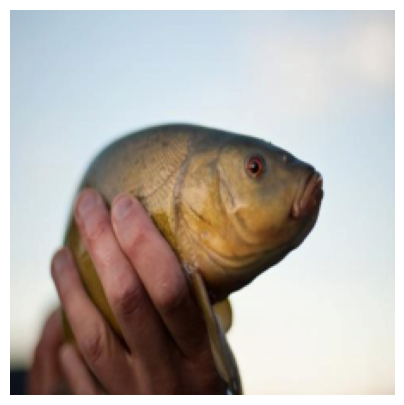

In [13]:
img = dst[1000][0]
img = torch.einsum('chw->hwc', img)
plt.rcParams['figure.figsize'] = [5, 5]
show_image(img)

In [7]:
def get_batched_imgs(label, num_imgs):
    order = [2, 0, 3, 4, 9, 7, 1, 8, 6, 5]
    batched_imgs = None

    s = order.index(label)
    # print(s)

    for i in range(947*s, 947*(s+1)):
        img, lbl = dst[i]
        if lbl == label:
            if batched_imgs is None:
                batched_imgs = img.unsqueeze(dim=0)
            else:
                batched_imgs = torch.cat([batched_imgs, img.unsqueeze(dim=0)], dim=0)
                if batched_imgs.shape[0] == num_imgs:
                    break

    print(f"Got {num_imgs} images of class {label}, with shape", batched_imgs.shape)
    return batched_imgs

In [8]:
class ActivationHook:
    """Hook to capture activations from a specific layer."""
    def __init__(self):
        self.activation = None
    
    def __call__(self, module, input, output):
        self.activation = output.detach()

def get_mae_activations(images, layer_name: str = 'decoder_embed', mask_ratio: float = 0.75):
    """
    Get activations from a specific layer of the model.
    
    Args:
        images: tensor[b, c=3, h, w]
    
    Returns:
        torch.Tensor: Activations from the specified layer
    """
    
    # Get the specific layer
    layer = None
    for name, module in model_mae.named_modules():
        if name == layer_name:
            layer = module
            break
    
    if layer is None:
        raise ValueError(f"Layer {layer_name} not found. Available layers: {[name for name, _ in model.named_modules()]}")
    
    # Register the forward hook
    hook = ActivationHook()
    handle = layer.register_forward_hook(hook)
    
    # Forward pass
    _, _, _ = model_mae(images, mask_ratio = mask_ratio)
    
    # Remove the hook
    handle.remove()
    
    return hook.activation

In [9]:
import skdim

def ID_estim(act, danco=False, corr=True, MLE=True, twoNN=True, local=True):
    """
    act: torch.tensor, shape (N, D)
    local: whether to run lpca estimation
    """
    results = {}

    if danco:
        result = skdim.id.DANCo().fit_transform(act)
        results['DANCo'] = result
        print("DANCo estimate:", result)

    if corr:
        result = skdim.id.CorrInt().fit_transform(act)
        results['CorrInt'] = result
        print("CorrDim estimate:", result)
    
    if MLE:
        result = skdim.id.MLE().fit_transform(act)
        results['MLE'] = result
        print("MLE estimate:", result)

    if twoNN:
        result = skdim.id.TwoNN().fit_transform(act)
        results['TwoNN'] = result
        print("TwoNN estimate:", result)
    
    if local:
        result = skdim.id.lPCA().fit_transform(act)
        results['lPCA'] = result
        print("lPCA estimate:", result)
    
    # L = []
    # for k in local:
    #     #estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
    #     result_FO = skdim.id.lPCA(ver='FO').fit_pw(act, n_neighbors = k, n_jobs = 1)
    #     meow_FO = np.mean(result_FO.dimension_pw_)
    #     L.append((k, meow_FO))
    #     print(f"lPCA estimate with {k} neighbors:", meow_FO)
    
    return results

In [10]:
from sklearn.decomposition import PCA

def PCA_estim(act, threshold=0.95):
    """
    act: torch.tensor, shape (N, D)
    threshold: float, the minimum variance to explain
    """
    pca = PCA()
    pca.fit(act)

    explained_variance_ratios = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratios)
    num_components = np.searchsorted(cumulative_variance, threshold) + 1

    return num_components

def PCA_estim2(act, alpha=0.05):
    pca = PCA()
    pca.fit(act)
    eigenvalues = pca.explained_variance_
    largest_eigenvalue = np.max(eigenvalues)
    # print(eigenvalues)
    num_components = np.sum(eigenvalues > alpha * largest_eigenvalue)
    return num_components


In [13]:
import einops
from ripser import ripser
import persim

def test_suite(i, batch_size, mask_ratio, shuffle=False):
    batched_imgs = get_batched_imgs(i, batch_size)
    if shuffle:
        batched_imgs = shuffle_images(batched_imgs)
    act = get_mae_activations(batched_imgs, mask_ratio=mask_ratio)
    act_all_patches = einops.rearrange(act, 'b p d -> (b p) d')
    print("Shape of activations:", act_all_patches.shape)

    # diagrams = ripser(act_all_patches)['dgms']
    # persim.plot_diagrams(diagrams, show=True)

    result = ID_estim(act_all_patches)
    # x, y, z = zip(*L)
    # plt.plot(x, y, marker='o', linestyle='-', color='b', label='Data points')
    # plt.plot(x, z, marker='o', linestyle='-', color='r', label='Data points')
    # plt.xlabel('num_neighbors')
    # plt.ylabel('lPCA dim')
    # plt.show()
    
    result["GlobalPCA"] = PCA_estim(act_all_patches)
    print("Global PCA dimension:", PCA_estim(act_all_patches))
    return result

In [14]:
all_results_no_shuffle = {}
for i in range(5):
    all_results_no_shuffle[i] = {}
    for ratio in [0, 0.25, 0.5, 0.75, 0.9]:
        all_results_no_shuffle[i][ratio] = test_suite(i, int(20/(1-ratio)), ratio, shuffle=True)

Got 20 images of class 0, with shape torch.Size([20, 3, 224, 224])
Shape of activations: torch.Size([3940, 512])
CorrDim estimate: 10.987508201549964
MLE estimate: 24.109807927975904
TwoNN estimate: 20.903492086652196
lPCA estimate: 15
Global PCA dimension: 198
Got 26 images of class 0, with shape torch.Size([26, 3, 224, 224])
Shape of activations: torch.Size([3848, 512])
CorrDim estimate: 11.91259101124495
MLE estimate: 25.04331472699129
TwoNN estimate: 21.18825420815993
lPCA estimate: 15
Global PCA dimension: 206
Got 40 images of class 0, with shape torch.Size([40, 3, 224, 224])
Shape of activations: torch.Size([3960, 512])
CorrDim estimate: 13.522623955727692
MLE estimate: 25.816090314826738
TwoNN estimate: 20.971535391934708
lPCA estimate: 16
Global PCA dimension: 214
Got 80 images of class 0, with shape torch.Size([80, 3, 224, 224])
Shape of activations: torch.Size([4000, 512])
CorrDim estimate: 12.789938803984574
MLE estimate: 28.496722448107075
TwoNN estimate: 22.60335357167168


In [21]:
all_results = {}
for i in range(5):
    all_results[i] = {}
    for ratio in [0, 0.25, 0.5, 0.75, 0.9]:
        all_results[i][ratio] = test_suite(i, int(20/(1-ratio)), ratio, shuffle=True)

Got 20 images of class 0, with shape torch.Size([20, 3, 224, 224])
Shape of activations: torch.Size([3940, 512])
CorrDim estimate: 11.018950860984788
MLE estimate: 24.33721170345232
TwoNN estimate: 21.566009830686717
lPCA estimate: 15
Global PCA dimension: 199
Got 26 images of class 0, with shape torch.Size([26, 3, 224, 224])
Shape of activations: torch.Size([3848, 512])
CorrDim estimate: 11.87144669229934
MLE estimate: 24.72424296314895
TwoNN estimate: 20.509346340357933
lPCA estimate: 15
Global PCA dimension: 206
Got 40 images of class 0, with shape torch.Size([40, 3, 224, 224])
Shape of activations: torch.Size([3960, 512])
CorrDim estimate: 13.468927874022276
MLE estimate: 26.0737425165116
TwoNN estimate: 21.615550894410884
lPCA estimate: 15
Global PCA dimension: 215
Got 80 images of class 0, with shape torch.Size([80, 3, 224, 224])
Shape of activations: torch.Size([4000, 512])
CorrDim estimate: 13.326706165173505
MLE estimate: 28.159030947044265
TwoNN estimate: 22.885406303523485
l

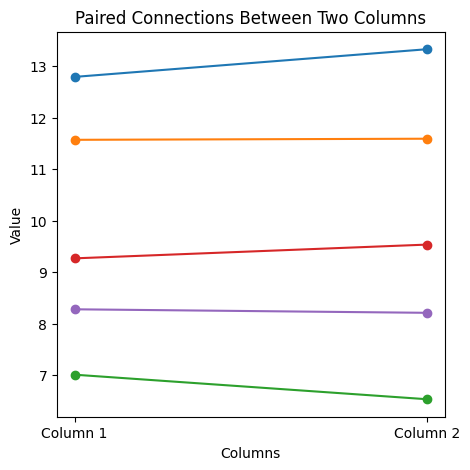

In [28]:
import matplotlib.pyplot as plt

# Your provided data, each row corresponds to a pair:
data = [
    [12.789938803984574, 13.326706165173505],
    [11.569301188972595, 11.590602812410287],
    [7.012882240687392, 6.537025223907224],
    [9.269669879064669, 9.536508706019113],
    [8.281438807926396, 8.213272747730889]
]

# Iterate over each pair and plot a line connecting them
for pair in data:
    y1 = pair[0]  # value in the first column
    y2 = pair[1]  # corresponding value in the second column
    plt.plot([1, 2], [y1, y2], marker='o', linestyle='-')

# Set the tick labels for the two columns
plt.xticks([1, 2], ['Column 1', 'Column 2'])

# Add axis labels and a title
plt.xlabel('Columns')
plt.ylabel('Value')
plt.title('Paired Connections Between Two Columns')

# Display the plot
plt.show()


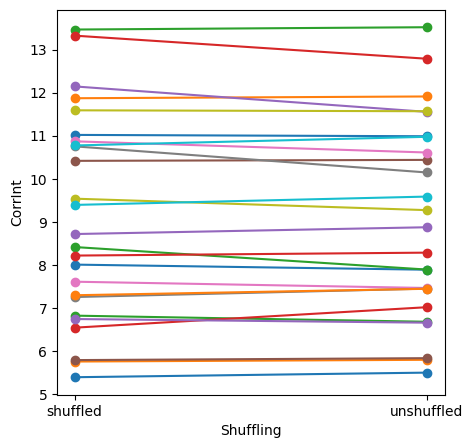

In [43]:
import matplotlib.pyplot as plt

method = 'CorrInt'
data = []
for i in range(5):
    for ratio in [0, 0.25, 0.5, 0.75, 0.9]:
        data.append([all_results[i][ratio][method], all_results_no_shuffle[i][ratio][method]])

# We'll have columns at positions x = 1, 2, 3, 4, and 5
x_positions = [1, 2]

# Plot each row of data as a line connecting the 5 points
for row in data:
    plt.plot(x_positions, row, marker='o', linestyle='-')

# Label the x-axis ticks to indicate the column numbers
plt.xticks(x_positions, ['shuffled', 'unshuffled'])

# Add labels and title
plt.xlabel('Shuffling')
plt.ylabel(method)

# Display the plot
plt.show()


In [ ]:
for i in range(5):
    print()

10.987508201549964 11.91259101124495 13.522623955727692 12.789938803984574 11.554599766414565
10.43792225300482 10.609742407895656 10.145336219761354 11.569301188972595 10.974926003748845
5.491828443969964 5.789812074640088 6.674280412973975 7.012882240687392 6.653191973431248
5.82799561832527 7.459796978805895 7.445333654465122 9.269669879064669 9.585010748560569
7.884551197712235 7.44080941541028 7.88783099269721 8.281438807926396 8.871990198907934


In [27]:
for i in range(5):
    print(all_results_no_shuffle[i][0.5]['CorrInt'], all_results[i][0.5]['CorrInt'])

13.522623955727692 13.468927874022276
10.145336219761354 10.752865106575912
6.674280412973975 6.816708498033679
7.445333654465122 7.2492332702251066
7.88783099269721 8.411814117175341


Got 10 images of class 2, with shape torch.Size([10, 3, 224, 224])


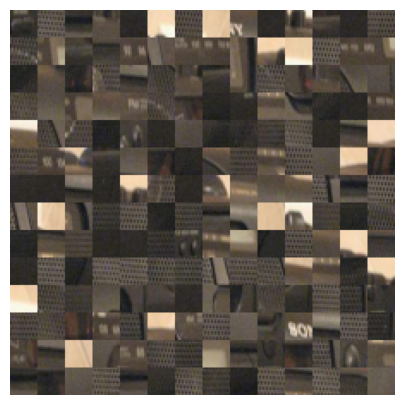

In [12]:
def shuffle_images(images):
    """
    images: (b, c=3, h=224, w=224)
    output: images with patches shuffled
    """
    images = einops.rearrange(images, 'b c (p1 h) (p2 w) -> b c h w (p1 p2)', p1 = 14, p2 = 14)
    images = images[:, :, :, :, torch.randperm(images.shape[4])]
    images = einops.rearrange(images, 'b c h w (p1 p2) -> b c (p1 h) (p2 w)', p1 = 14, p2 = 14)
    return images

images = get_batched_imgs(2, 10)
images = shuffle_images(images)

img = images[0]
img = torch.einsum('chw->hwc', img)
plt.rcParams['figure.figsize'] = [5, 5]
show_image(img)